In [1]:
import pandas as pd

In [2]:
training_df=pd.read_csv("../Datasets/training.csv")
training_df.fillna(0,inplace=True)
training_df.drop(['date','month'],axis=1,inplace=True)
training_df.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,fire
0,22.922499,58.003628,14.2225,22.934956,0.0,0.0,0.0,0.0,0.0,1016.0,...,23.759998,22.122500,23.972500,22.172499,18.5225,0.152,0.203,0.243,0.205,0
1,18.571500,81.909440,15.4215,18.963050,0.0,0.0,0.0,0.0,0.0,1016.4,...,18.000000,21.271502,22.671501,22.271502,20.3715,0.425,0.433,0.423,0.405,1
2,22.240500,27.772692,2.7405,18.372614,0.0,0.0,0.0,0.0,0.0,1022.5,...,37.800000,24.990500,19.740500,19.790499,18.7405,0.069,0.088,0.120,0.209,0
3,17.717500,96.893280,17.2175,19.324417,0.0,0.0,0.0,0.0,0.0,1016.8,...,9.000000,22.517500,25.717500,23.117500,22.2175,0.117,0.136,0.186,0.275,0
4,34.603500,29.610748,14.3035,36.488297,0.0,0.0,0.0,0.0,0.0,1005.2,...,18.720000,32.953503,27.253500,25.253500,24.0535,0.309,0.347,0.184,0.170,0


In [3]:
training_df.shape

(214545, 31)

In [4]:
X=training_df.drop('fire',axis=1)
y=training_df['fire']

In [5]:
"""
Standard Scaling for the numerical variables cause every column is in different units - Centigrade, centimeter, millimeter etc
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def feature_transformation(encode_df):
    num_attributes=encode_df.columns.to_list()
    numeric_pipeline=Pipeline([
        ('std_scaler',StandardScaler())
    ])
    encoder_pipeline=ColumnTransformer([
        ("numeric_var",numeric_pipeline,num_attributes),
    ])
    df_encoded=encoder_pipeline.fit_transform(encode_df)
    return df_encoded,encoder_pipeline
X_transformed=feature_transformation(X)[0]

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import optuna
from sklearn.metrics import accuracy_score

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [8]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1,verbose=True)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.4s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=True)

In [10]:
"""
Built a random forest model and displayed the best features based on Gini Importance
"""
importances = rf.feature_importances_
feature_names=X.columns
feature_imp_df = pd.DataFrame({'Feature': X.columns.tolist(), 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
15,et0_fao_evapotranspiration,0.117260
16,vapour_pressure_deficit,0.054482
1,relative_humidity_2m,0.053562
22,soil_temperature_0_to_7cm,0.052036
0,temperature_2m,0.050799
23,soil_temperature_7_to_28cm,0.050080
3,apparent_temperature,0.046413
9,pressure_msl,0.046006
24,soil_temperature_28_to_100cm,0.043598
18,wind_speed_100m,0.042560


In [11]:
"""
Analytically - The features with lower importance involve cloud cover, weather code, rain, snow.
Intuitively - You would expect rain, snow, weather code or cloud cover to have an effect on fire
"""
unimportant_features=feature_imp_df[feature_imp_df['Gini Importance']<(2/100)]['Feature'].tolist()

In [12]:
"""
This is an optional step because since we have only about 31 features, the only advantage of dropping features that are highly correlated is the increase in model building time
and not really the accuracy as seen below in the evaluation metrics. The AUC scores are pretty much the same
"""
high_correlated_features=['soil_temperature_7_to_28cm','wind_direction_10m','temperature_2m','soil_moisture_28_to_100cm',
                          'soil_moisture_7_to_28cm','soil_temperature_100_to_255cm','soil_temperature_28_to_100cm',
                          'soil_temperature_100_to_255cm','soil_moisture_100_to_255cm']

In [13]:
drop_features=unimportant_features+high_correlated_features
X.drop(drop_features,axis=1,inplace=True)
X.shape

(214545, 14)

In [14]:
X_transformed=feature_transformation(X)[0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
print(f"Mean Accuracy = {np.mean(scores):.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n

Mean Accuracy = 0.7930


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [16]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)  
    max_depth = trial.suggest_int('max_depth', 3, 20) 
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20) 
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


print(f"Best hyperparameters: {study.best_params}")

print(f"Best validation accuracy: {study.best_value}")

[I 2024-11-10 21:43:52,519] A new study created in memory with name: no-name-dae11353-5358-43ad-8d51-c995943461f0
[I 2024-11-10 21:43:56,330] Trial 0 finished with value: 0.7619147498193852 and parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.7619147498193852.
[I 2024-11-10 21:44:34,131] Trial 1 finished with value: 0.7420121652800112 and parameters: {'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': None, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7619147498193852.
[I 2024-11-10 21:44:58,729] Trial 2 finished with value: 0.7540376144864713 and parameters: {'n_estimators': 350, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.7619147498193852.
[I 2024-11-10 21:46:24,627] Trial 3 finished with value: 0.730779090

[I 2024-11-10 22:01:44,111] Trial 30 finished with value: 0.7236477195926263 and parameters: {'n_estimators': 400, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 26 with value: 0.7879232794984735.
[I 2024-11-10 22:02:19,354] Trial 31 finished with value: 0.7889487053997996 and parameters: {'n_estimators': 350, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 31 with value: 0.7889487053997996.
[I 2024-11-10 22:03:07,898] Trial 32 finished with value: 0.790137267239973 and parameters: {'n_estimators': 350, 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 32 with value: 0.790137267239973.
[I 2024-11-10 22:03:41,581] Trial 33 finished with value: 0.7888088745950733 and parameters: {'n_estimators': 250, 'max_depth': 19, 'min_samples_split': 13, 'min_samples_l

Best hyperparameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'criterion': 'entropy'}
Best validation accuracy: 0.7955207532219348


In [17]:
best_params=study.best_params

In [18]:
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                            min_samples_split=best_params['min_samples_split'],
                            min_samples_leaf=best_params['min_samples_leaf'],
                            max_features=best_params['max_features'],
                            max_depth=best_params['max_depth'],
                            criterion=best_params['criterion'],
                            n_jobs=-1)

In [19]:
X_transformed=feature_transformation(X)[0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=23)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, max_features=None,
                       min_samples_leaf=4, min_samples_split=10, n_jobs=-1)

In [20]:
y_pred=rf.predict(X_test)
y_scores = rf.predict_proba(X_test)[:, 1]

In [21]:
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
import matplotlib.pyplot as plt
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77     21285
           1       0.76      0.88      0.81     21624

    accuracy                           0.79     42909
   macro avg       0.80      0.79      0.79     42909
weighted avg       0.80      0.79      0.79     42909



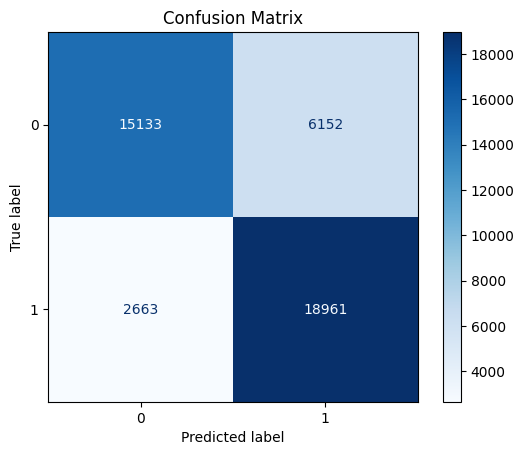

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

AUC-ROC Score: 0.8741157716249991


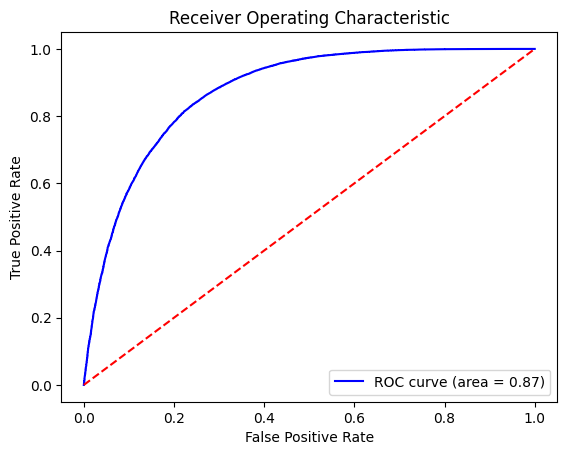

In [23]:
auc_score = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_score)


fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()